## Setup

In [353]:
# from google.colab import auth
# from google.cloud import bigquery
# from google.colab import data_table
# from google.colab import widgets

# from collections import Counter
# import re
# import numpy as np
# import pandas as pd
# import math



In [354]:
# import os
# from google.colab import drive
# import sys

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/HML/Final Project')
# sys.path.append(os.path.abspath('/content/drive/MyDrive/HML/Final Project'))

In [355]:
# !pip install duckdb --quiet
# import duckdb

In [356]:
# drive_path = '/content/drive/MyDrive/HML/Final Project/MIMIC-III'
# con = duckdb.connect(f'{drive_path}/mimiciii.duckdb')

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

import torch
from torch_geometric.nn import GATv2Conv
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tensorflow.keras.preprocessing.sequence import pad_sequences


/home/bnet/kupershmidt/anaconda3/envs/spider/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-20 17:17:51.568722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755699471.582340 3076093 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755699471.586418 3076093 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755699471.598089 3076093 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target

## Loading data

In [4]:
subject_ids = pd.read_csv('data/initial_cohort.csv')['subject_id'].to_list()
lavbevent_meatdata = pd.read_csv('data/labs_metadata.csv')
vital_meatdata = pd.read_csv('data/vital_metadata.csv')

In [4]:
ICUQ = \
"""--sql
SELECT admissions.subject_id::INTEGER AS subject_id, admissions.hadm_id::INTEGER AS hadm_id
, admissions.admittime::DATE AS admittime, admissions.dischtime::DATE AS dischtime
, admissions.ethnicity, admissions.deathtime::DATE AS deathtime
, patients.gender, patients.dob::DATE AS dob, icustays.icustay_id::INTEGER AS icustay_id, patients.dod::DATE as dod,
icustays.intime::DATE AS intime,icustays.outtime::DATE AS outtime
FROM admissions
INNER JOIN patients
    ON admissions.subject_id = patients.subject_id
LEFT JOIN icustays
    ON admissions.hadm_id = icustays.hadm_id

WHERE admissions.has_chartevents_data = 1
AND admissions.subject_id::INTEGER IN ?
ORDER BY admissions.subject_id, admissions.hadm_id, admissions.admittime;
"""

# icu =  con.execute(ICUQ, [subject_ids]).fetchdf().rename(str.lower, axis='columns')


In [5]:
LABQUERY = \
f"""--sql
SELECT labevents.subject_id::INTEGER AS subject_id\
      , labevents.hadm_id::INTEGER AS hadm_id\
      , labevents.charttime::DATE AS charttime
      , labevents.itemid::INTEGER AS itemid\
      , labevents.valuenum::DOUBLE AS valuenum
      , admissions.admittime::DATE AS admittime
FROM labevents
          INNER JOIN admissions
                    ON labevents.subject_id = admissions.subject_id
                        AND labevents.hadm_id = admissions.hadm_id
                        AND labevents.charttime::DATE between
                            (admissions.admittime::DATE)
                            AND (admissions.admittime::DATE + interval 48 hour)
                        AND itemid::INTEGER IN ? \
                        """

VITQUERY = f"""--sql
        SELECT chartevents.subject_id::INTEGER AS subject_id\
             , chartevents.hadm_id::INTEGER AS hadm_id\
             , chartevents.charttime::DATE AS charttime\
             , chartevents.itemid::INTEGER AS itemid\
             , chartevents.valuenum::DOUBLE AS valuenum\
             , admissions.admittime::DATE AS admittime\
        FROM chartevents
                 INNER JOIN admissions
                            ON chartevents.subject_id = admissions.subject_id
                                AND chartevents.hadm_id = admissions.hadm_id
                                AND chartevents.charttime::DATE between
                                   (admissions.admittime::DATE)
                                   AND (admissions.admittime::DATE + interval 48 hour)
                                AND itemid::INTEGER in ?
      -- exclude rows marked as error
      AND chartevents.error::INTEGER IS DISTINCT \
        FROM 1 \
        """


# lab = con.execute(LABQUERY, [lavbevent_meatdata['itemid'].tolist()]).fetchdf().rename(str.lower, axis='columns')
# vit = con.execute(VITQUERY, [vital_meatdata['itemid'].tolist()]).fetchdf().rename(str.lower, axis='columns')

In [5]:
pred_window = 13*24      # duration of prediction window (hours)
pred_gap = 24            # minimal gap between prediction and target (hours)
min_los = 24             # minimal length of stay (hours)
min_target_onset = 2*24  # minimal time of target since admission (hours)
pred_freq = '4H'        # prediction frequency

labs = pd.read_csv('data/labs.csv')
vits = pd.read_csv('data/vits.csv')
hosps = pd.read_csv('data/icu.csv')

for col in ['admittime', 'dischtime', 'dob', 'dod', 'intime', 'outtime']:
    hosps[col] = pd.to_datetime(hosps[col].str.strip(), errors='coerce')

In [ ]:
# Create labels for each subject_id and hadm_id combination
def create_labels(hosps):
    """
    Create three labels for each subject_id and hadm_id:
    1. 30-day mortality (died within 30 days of discharge or during admission)
    2. Prolonged stay (length of stay > 7 days)
    3. 30-day readmission (readmitted within 30 days of discharge)
    """
    
    hosps_sorted = hosps.sort_values(['subject_id', 'admittime'])[['subject_id','hadm_id', 'admittime','dischtime','dod']].drop_duplicates().copy()
    hosps_sorted['los_hosp_hr'] = (hosps_sorted['dischtime'] - hosps_sorted['admittime']).dt.total_seconds()/3600
    hosps_sorted['mort_30day'] = 0
    
    died_during_admission = (~hosps_sorted['dod'].isna()) & (hosps_sorted['dod'] <= hosps_sorted['dischtime'])
    hosps_sorted.loc[died_during_admission, 'mort_30day'] = 1
    days_to_death_post_discharge = (hosps_sorted['dod'] - hosps_sorted['dischtime']).dt.total_seconds() / (24 * 3600)
    died_within_30_days = (~hosps_sorted['dod'].isna()) & (days_to_death_post_discharge <= 30) & (days_to_death_post_discharge >= 0)
    hosps_sorted.loc[died_within_30_days, 'mort_30day'] = 1
    
    hosps_sorted['prolonged_stay'] = (hosps_sorted['los_hosp_hr'] > 7 * 24).astype(int)
    hosps_sorted['readmission_30day'] = 0
    
    hosps_sorted['next_admittime'] = hosps_sorted.groupby('subject_id')['admittime'].shift(-1)
    days_between = (hosps_sorted['next_admittime'] - hosps_sorted['dischtime']).dt.total_seconds() / (24 * 3600)
    hosps_sorted['readmission_30day'] = ((days_between > 0) & (days_between <= 30)).astype(int)
    
    return hosps_sorted[['subject_id', 'hadm_id', 'mort_30day', 'prolonged_stay', 'readmission_30day']]

labels_df = create_labels(hosps)
print("Labels created successfully!")
print(f"Shape: {labels_df.shape}")
print("\nLabel distributions:")
print(f"30-day mortality: {labels_df['mort_30day'].sum()} / {len(labels_df)} ({labels_df['mort_30day'].mean():.3f})")
print(f"Prolonged stay: {labels_df['prolonged_stay'].sum()} / {len(labels_df)} ({labels_df['prolonged_stay'].mean():.3f})")
print(f"30-day readmission: {labels_df['readmission_30day'].sum()} / {len(labels_df)} ({labels_df['readmission_30day'].mean():.3f})")

Labels created successfully!
Shape: (40156, 5)

Label distributions:
30-day mortality: 5671 / 40156 (0.141)
Prolonged stay: 17308 / 40156 (0.431)
30-day readmission: 2147 / 40156 (0.053)


## preprocessing

In [7]:
# ethnicity  - to category
hosps.ethnicity = hosps.ethnicity.str.lower()
hosps.loc[(hosps.ethnicity.str.contains('^white')),'ethnicity'] = 'white'
hosps.loc[(hosps.ethnicity.str.contains('^black')),'ethnicity'] = 'black'
hosps.loc[(hosps.ethnicity.str.contains('^hisp')) | (hosps.ethnicity.str.contains('^latin')),'ethnicity'] = 'hispanic'
hosps.loc[(hosps.ethnicity.str.contains('^asia')),'ethnicity'] = 'asian'
hosps.loc[~(hosps.ethnicity.str.contains('|'.join(['white', 'black', 'hispanic', 'asian']))),'ethnicity'] = 'other'

# ethnicity - one hot encoding
hosps['eth_white'] = (hosps['ethnicity'] == 'white').astype(int)
hosps['eth_black'] = (hosps['ethnicity'] == 'black').astype(int)
hosps['eth_hispanic'] = (hosps['ethnicity'] == 'hispanic').astype(int)
hosps['eth_asian'] = (hosps['ethnicity'] == 'asian').astype(int)
hosps['eth_other'] = (hosps['ethnicity'] == 'other').astype(int)
hosps.drop(['ethnicity', 'deathtime'], inplace=True, axis=1)

In [8]:

# Generate feature columns for los, age and mortality
def age(admittime, dob):
    if admittime < dob:
      return 0
    return admittime.year - dob.year - ((admittime.month, admittime.day) < (dob.month, dob.day))

hosps['age'] = hosps.apply(lambda row: age(row['admittime'], row['dob']), axis=1)
hosps['los_hosp_hr'] = (hosps.dischtime - hosps.admittime).dt.total_seconds()/3600
hosps['mort'] = np.where(~np.isnat(hosps.dod),1,0)

# Gender to binary
hosps['gender'] = np.where(hosps['gender']=="M", 1, 0)

# @title Q1.1 - Patient Exclusion Criteria
hosps = hosps.sort_values('admittime').groupby('subject_id').first().reset_index()
print(f"1. Include only first admissions: N={hosps.shape[0]}")

hosps = hosps[hosps.age.between(18,90)]
print(f"2. Exclusion by ages: N={hosps.shape[0]}")

# Exclude patients hospitalized for less than 24 hours
hosps = hosps[hosps['los_hosp_hr'] >= min_los]
print(f"3. Include only patients who admitted for at least {min_los} hours: N={hosps.shape[0]}")

# Exclude patients that died in the first 48 hours of admission
hours_to_death = (hosps['dod'] - hosps['admittime']).dt.total_seconds() / 3600
hosps = hosps[~((hosps['mort'].astype(bool)) & (hours_to_death < min_target_onset))]
print(f"4. Exclude patients who died within {min_target_onset}-hours of admission: N={hosps.shape[0]}")

1. Include only first admissions: N=32513
2. Exclusion by ages: N=25548
3. Include only patients who admitted for at least 24 hours: N=25168
4. Exclude patients who died within 48-hours of admission: N=24825


In [9]:
labs = labs[labs['hadm_id'].isin(hosps['hadm_id'])]
labs = pd.merge(labs,lavbevent_meatdata,on='itemid')
labs = labs[labs['valuenum'].between(labs['min'],labs['max'],  inclusive='both')]

vits = vits[vits['hadm_id'].isin(hosps['hadm_id'])]
vits = pd.merge(vits,vital_meatdata,on='itemid')
vits = vits[vits['valuenum'].between(vits['min'],vits['max'], inclusive='both')]

vits.loc[(vits['feature name'] == 'TempF'),'valuenum'] = (vits[vits['feature name'] == 'TempF']['valuenum']-32)/1.8
vits.loc[vits['feature name'] == 'TempF','feature name'] = 'TempC'

merged = pd.concat([vits, labs])
merged['charttime'] = pd.to_datetime(merged['charttime'], errors='coerce')

pivot = pd.pivot_table(merged, index=['subject_id', 'hadm_id', pd.Grouper(key='charttime', freq=pred_freq)],
                       columns=['feature name'], values='valuenum', aggfunc=['mean', 'max', 'min', 'std'])
pivot.columns = [f'{c[1]}_{c[0]}' for c in pivot.columns.to_flat_index()]

# temp = merged.copy()

merged = pd.merge(hosps, pivot.reset_index(), on=['subject_id', 'hadm_id'])
merged[pivot.columns] = merged.groupby(['subject_id', 'hadm_id'])[pivot.columns].ffill()


/tmp/ipykernel_3076093/9803228.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pivot = pd.pivot_table(merged, index=['subject_id', 'hadm_id', pd.Grouper(key='charttime', freq=pred_freq)],


In [10]:
merged = merged.sort_values(['subject_id', 'hadm_id', 'charttime'])
labs_features_names = set(labs['feature name'])
vits_features_names = set(vits['feature name'])
labs_features = [col for col in merged.columns if col.split('_')[0] in labs_features_names]
vits_features = [col for col in merged.columns if col.split('_')[0] in vits_features_names]

lab_diff_cols = {}
for col in labs_features:
    if col.find("mean") >= 0:
      base = merged.groupby(['subject_id', 'hadm_id'])[col].transform('first')
      lab_diff_cols[f'{col}_diff'] = merged[col] - base

lab_diff_df = pd.DataFrame(lab_diff_cols)

vital_diff_cols = {}
for col in vits_features:
  if col.find("mean") >= 0:
      diff_series = merged.groupby(['subject_id', 'hadm_id'])[col].diff()
      vital_diff_cols[f'{col}_diff'] = diff_series

vital_diff_df = pd.DataFrame(vital_diff_cols)

# Concatenate back to original DataFrame
merged = pd.concat([merged, lab_diff_df, vital_diff_df], axis=1)

In [11]:
merged['charttime'] = pd.to_datetime(merged['charttime'], errors='coerce')

time_to_death = (merged['dod'] - merged['charttime']).dt.total_seconds() / (60 * 60)
merged['target'] = (pd.notnull(time_to_death) & (time_to_death <= pred_window + pred_gap)).astype(int)
merged = merged[time_to_death.isna() | (time_to_death >= pred_gap)]

In [13]:
#min_max_chartime = merged.groupby("subject_id").agg({"charttime": ["min", "max"]})
#min_max_chartime.columns = ['min_charttime', 'max_charttime']
#min_max_chartime.to_csv('data/min_max_chartime.csv')

In [12]:
merged.loc[merged.target==1, "subject_id"].drop_duplicates()

25            9
52           12
130          31
398          84
508         101
          ...  
279121    99740
279186    99768
279470    99881
279524    99899
279616    99955
Name: subject_id, Length: 1986, dtype: int64

In [54]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

merged_clean = merged.reset_index(drop=True)

np.random.seed(0)

#Split to train & test (all data of a single patient needs to be in the same group)
X = merged_clean
X = X.merge(labels_df, on=['subject_id', 'hadm_id'], how='inner')
groups = merged_clean['subject_id']

gss = GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.1)
train_index, test_index = next(gss.split(X, groups=groups))
val_index = list(set(X.index.to_list()) - (set(train_index.tolist()) | set(test_index.tolist())))

X_train = X.iloc[train_index]
X_val = X.iloc[val_index]
X_test = X.iloc[test_index]

y_train = X_train[["subject_id","mort_30day","prolonged_stay","readmission_30day"]].drop_duplicates()
y_train = y_train.groupby('subject_id',as_index=False).max()

X_train.drop(columns=["target","mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)

y_val = X_val[["subject_id","mort_30day","prolonged_stay","readmission_30day"]].drop_duplicates()
y_val = y_val.groupby('subject_id',as_index=False).max()
X_val.drop(columns=["target","mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)

y_test = X_test[["subject_id","mort_30day","prolonged_stay","readmission_30day"]].drop_duplicates()
y_test = y_test.groupby('subject_id',as_index=False).max()
X_test.drop(columns=["target","mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)

/tmp/ipykernel_3076093/1053642204.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=["target","mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)
/tmp/ipykernel_3076093/1053642204.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.drop(columns=["target","mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)
/tmp/ipykernel_3076093/1053642204.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [55]:
import sys, numpy
import pickle
# Create an alias so pickle can find the old path
sys.modules["numpy._core.numeric"] = numpy.core.numeric  

with open("data/notes_with_embeddings.pkl", "rb") as f:
    notes = pickle.load(f)
    notes_ordered = X[['subject_id']].drop_duplicates().merge(
    notes[["subject_id","embeddings"]], 
    on='subject_id', 
    how='left'
)

    embeddings_dict = {}

for idx, row in notes_ordered.iterrows():
    subject_id = row['subject_id']
    embeddings = row['embeddings']
    try:
        if isinstance(embeddings, np.ndarray) :
            # Convert to tensor if it's not already
            if not isinstance(embeddings, torch.Tensor):
                embeddings = torch.tensor(embeddings, dtype=torch.float32)
            
            # Perform average pooling across the sequence dimension
            # Assuming embeddings shape is (sequence_length, embedding_dim)
            pooled_embedding = torch.mean(embeddings, dim=0)  # Shape: (embedding_dim,)
            embeddings_dict[subject_id] = pooled_embedding
        else:
            # Handle missing embeddings with zero vector
            # Assuming embedding dimension is 768 (common for transformers)
            embeddings_dict[subject_id] = torch.zeros(768, dtype=torch.float32)
    except Exception as e:
        flag = 1

# Convert to a tensor where each row corresponds to a subject_id
subject_ids_list = notes_ordered['subject_id'].tolist()
pooled_embeddings = [embeddings_dict[subject_id] for subject_id in subject_ids_list]

print(f"Pooled embeddings shape: {len(pooled_embeddings)}")
print(f"Number of subjects: {len(subject_ids_list)}")

notes_df = pd.DataFrame({
    'subject_id': subject_ids_list,
    'embeddings': pooled_embeddings}).set_index('subject_id')

notes_df_train = notes_df.loc[X_train.subject_id.unique()]
notes_df_val = notes_df.loc[X_val.subject_id.unique()]
notes_df_test = notes_df.loc[X_test.subject_id.unique()]

Pooled embeddings shape: 24796
Number of subjects: 24796


In [56]:
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include='float').columns
scaler = StandardScaler()

X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
X_val.loc[:, num_cols] = scaler.transform(X_val[num_cols])
X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])

baseline_df = X_train[X_train.charttime.dt.date == X_train.admittime.dt.date].mean(axis=0).fillna(0)
X_train.loc[:, num_cols] = X_train[num_cols].fillna(baseline_df)
X_val.loc[:, num_cols] = X_val[num_cols].fillna(baseline_df)
X_test.loc[:, num_cols] = X_test[num_cols].fillna(baseline_df)

In [57]:
to_drop = ['hadm_id','icustay_id','intime','outtime','admittime', 'dischtime', 'dod','dob', 'mort', 'los_hosp_hr', 'charttime','adm_to_death']

to_keep = ~X_train.columns.isin(to_drop)
to_keep = X_train.columns[to_keep]
X_train = X_train[to_keep]
X_test = X_test[to_keep]
X_val = X_val[to_keep]

In [58]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_and_select_subjects(X_train, num_clusters=10, random_state=42):
    """
    Calculate the first row of each subject_id in X_train, cluster it to num_clusters 
    and choose one subject_id from each cluster.
    
    Parameters:
    X_train: DataFrame with subject_id column
    num_clusters: int, number of clusters to create
    random_state: int, for reproducibility
    
    Returns:
    list: selected subject_ids, one from each cluster
    """
    first_rows = X_train.groupby('subject_id').first().reset_index()
    
    features_for_clustering = first_rows.drop('subject_id', axis=1)
    

    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(features_for_clustering)
    

    first_rows['cluster'] = cluster_labels
    

    np.random.seed(random_state)
    selected_subjects = []
    
    for cluster_id in range(num_clusters):
        cluster_subjects = first_rows[first_rows['cluster'] == cluster_id]['subject_id'].values
        if len(cluster_subjects) > 0:
            selected_subject = np.random.choice(cluster_subjects)
            selected_subjects.append(selected_subject)
    
    return selected_subjects

selected_subjects = cluster_and_select_subjects(X_train, num_clusters=100, random_state=42)

In [59]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create X_core with rows where subject_id is in selected_subjects
X_core = X_train[X_train['subject_id'].isin(selected_subjects)]
y_core = y_train[y_train['subject_id'].isin(selected_subjects)]

# Update X_train to exclude the selected subjects
X_train = X_train[~X_train['subject_id'].isin(selected_subjects)]
y_train = y_train[~y_train['subject_id'].isin(selected_subjects)]

train_labels = torch.tensor(y_train[['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
val_labels = torch.tensor(y_val[['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
test_labels = torch.tensor(y_test[['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)

In [60]:
def generate_series_data(df, group_col="subject_id", maxlen=18):
  grouped = df.groupby(group_col)
  subject_sequences = [group.values[:, 1:] for _, group in grouped]
  padded_tensor = pad_sequences(subject_sequences, padding='post', dtype='float32')
  sequence_lengths = [len(seq) for seq in subject_sequences]
  padding_mask = np.zeros((len(sequence_lengths), maxlen), dtype=np.float32)
  for i, length in enumerate(sequence_lengths):
      padding_mask[i, :length] = 1.0
  padded_tensor = torch.tensor(padded_tensor, dtype=torch.float32)
  padding_mask = torch.tensor(padding_mask, dtype=torch.float32)
  return padded_tensor, padding_mask

In [20]:
#import NoteEmbedder
#import imp
#os.environ["TRANSFORMERS_CACHE"] = "/home/bnet/ronsheinin/MLHC/MLHC/cache"
#imp.reload(NoteEmbedder)
#import os
#notes = pd.read_csv('data/notes.csv')
#note_embeddings = NoteEmbedder.run_embeeding(notes)

## Model

In [24]:
import torch
from torch.utils.data import Dataset


class PatientDataset(Dataset):
    def __init__(self, X, y, padding_mask, notes,  k=5, single_patient=False):
        # self.core = core
        self.X = X
        self.y = y
        self.padding_mask = padding_mask
        # self.padding_mask_core = padding_mask_core
        self.k = k
        self.notes = notes
        self.single_patient = single_patient
        if self.single_patient:
            self.cal_graphs()

        self.edge_list = None

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.padding_mask[idx], self.notes[idx]
    def cal_graphs(self):
        if self.edge_list is not None:
            return self.edge_list
        
        edge_list = []
        for patient_idx in range(len(self.X)):
            edges = self.build_knn_graph(self.X[patient_idx:patient_idx+1], self.core, 
                                                self.padding_mask[patient_idx:patient_idx+1], self.padding_mask_core, k=self.k)
            edge_list.append(edges)
        self.edge_list = torch.cat(edge_list, dim=1).T
        
    @staticmethod
    def build_knn_graph(batch, core, padding_mask_batch, padding_mask_core, k=5):
        """
        Build a KNN graph from batch and core tensors.
        
        Args:
            batch: 3D tensor (batch_size, seq_len, features)
            core: 3D tensor (core_size, seq_len, features)
            padding_mask_batch: 2D tensor (batch_size, seq_len) indicating valid time points
            padding_mask_core: 2D tensor (core_size, seq_len) indicating valid time points
            k: number of nearest neighbors for patient connections
        
        Returns:
            edge_index: tensor of shape (2, num_edges) representing graph edges
        """
        batch_size, seq_len, _ = batch.shape
        core_size = core.shape[0]
        total_patients = batch_size + core_size
        batch_size = batch.shape[0]

        all_patients = torch.cat([batch, core], dim=0)
        all_padding_mask = torch.cat([padding_mask_batch, padding_mask_core], dim=0)
        
        edges = []
        
        for patient_idx in range(total_patients):
            for t in range(seq_len - 1):
            
                if all_padding_mask[patient_idx, t] > 0 and all_padding_mask[patient_idx, t + 1] > 0:
                    node_curr = patient_idx * seq_len + t
                    node_next = patient_idx * seq_len + t + 1
   
                    edges.append([node_curr, node_next])
                    edges.append([node_next, node_curr])
        
        
        for t in range(seq_len):
            valid_patients = all_padding_mask[:, t] > 0
            valid_indices = torch.where(valid_patients)[0] 
            

            valid_patients_to = all_padding_mask[batch_size:, t] > 0
            valid_indices_to = torch.where(valid_patients_to)[0] + batch_size


            if len(valid_indices) > 1:
                features_t = all_patients[valid_indices, t, :]
                features_t_to = all_patients[valid_indices_to, t, :]

                distances = torch.cdist(features_t, features_t_to, p=2)
                
                for i, patient_idx in enumerate(valid_indices):
                    num_neighbors = min(k, len(valid_indices_to))
                    _, nearest_indices = torch.topk(distances[i], num_neighbors, largest=False)
                    
                    for j in nearest_indices:
                        neighbor_idx = valid_indices_to[j]
                        node_curr = patient_idx * seq_len + t
                        node_neighbor = neighbor_idx * seq_len + t
                        edges.append([node_neighbor, node_curr])
        
        if edges:
            edge_index = torch.tensor(edges, dtype=torch.long).t()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        
        return edge_index

#dataset = PatientDataset(core=padd_tensor_core, X=padded_tensor, y=labels, padding_mask=padding_mask, padding_mask_core=padding_mask_core, k=5)
# dataset.cal_graphs()

In [25]:
from sklearn.metrics import average_precision_score, roc_auc_score


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')  # For testing purposes, use CPU


class GraphGRUMortalityModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n1_gat_layers, n2_gru_layers, X_core, core_padding_mask,
                 num_heads=4, dropout=0.1, seq_len=18, k=5, gnn_flag=True):
        """
        Mortality prediction model with Graph Attention + GRU layers
        
        Args:
            input_dim: Input feature dimension
            hidden_dim: Hidden dimension for GAT and GRU layers
            n1_gat_layers: Number of Graph Attention layers
            n2_gru_layers: Number of GRU layers
            X_core_dim: Core set dimension (number of core patients)
            num_heads: Number of attention heads for GAT
            dropout: Dropout rate
            seq_len: Sequence length
        """
        super(GraphGRUMortalityModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n1_gat_layers = n1_gat_layers
        self.n2_gru_layers = n2_gru_layers
        self.X_core = X_core.to(DEVICE)
        self.core_padding_mask = core_padding_mask.to(DEVICE)
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.gnn_flag = gnn_flag


        self.notes_layer = nn.Linear(768, hidden_dim).to(DEVICE) 
        self.gat_layers = nn.ModuleList().to(DEVICE)
        
        self.gat_layers.append(
            GATv2Conv(input_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout, concat=True)
        )
        
        for _ in range(n1_gat_layers - 1):
            self.gat_layers.append(
                GATv2Conv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout, concat=True)
            )
        
        if self.gnn_flag:
            self.gru = nn.GRU(hidden_dim, hidden_dim, n2_gru_layers, batch_first=True, dropout=dropout)
        else:
            self.gru = nn.GRU(input_dim, hidden_dim, n2_gru_layers, batch_first=True, dropout=dropout)
        
        self.classifier = nn.Sequential(
            nn.Linear(4*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.dropout = nn.Dropout(dropout).to(DEVICE)
        self.k = k

        self.best_model = None

        # initialize weights
        for layer in self.gat_layers:
            if isinstance(layer, GATv2Conv):
                nn.init.xavier_uniform_(layer.lin_l.weight)
                nn.init.xavier_uniform_(layer.lin_r.weight) 
        nn.init.xavier_uniform_(self.gru.weight_ih_l0)
        nn.init.xavier_uniform_(self.gru.weight_hh_l0)
        nn.init.constant_(self.gru.bias_ih_l0, 0.0)
        nn.init.constant_(self.gru.bias_hh_l0, 0.0)
        
  
        
    def forward(self, x ,padding_mask, edge_index, nots):
        """
        Forward pass
        
        Args:
            core: Core patients tensor (X_core_dim, seq_len, input_dim)
            x: Batch patients tensor (batch_size, seq_len, input_dim)
            y: Target labels (batch_size, seq_len)
            padding_mask: Padding mask (batch_size, seq_len)
            edge_index: Graph edge indices (2, num_edges)
        
        Returns:
            predictions: Mortality predictions (batch_size, seq_len, 1)
        """
        batch_size = x.size(0)
        
        if self.gnn_flag:
            all_patients = torch.cat([x, self.X_core], dim=0)  # (batch_size + X_core_dim, seq_len, input_dim)
            total_patients = batch_size + self.X_core.shape[0]
            
            # Reshape for graph processing: (total_patients * seq_len, input_dim)
            graph_input = all_patients.view(total_patients * self.seq_len, -1)
            # Apply GAT layers
            for gat_layer in self.gat_layers:
                graph_input = F.relu(gat_layer(graph_input, edge_index))
                # graph_input = self.dropout(graph_input)
            
            # Reshape back to sequence format: (total_patients, seq_len, hidden_dim)
            graph_output = graph_input.view(total_patients, self.seq_len, -1)

            # Extract only batch patients (exclude core)
        
            batch_output = graph_output[:batch_size]  # (batch_size, seq_len, hidden_dim)
        
        else:
            batch_output = x
        # Apply GRU layers
        # Pack sequences for efficient processing
        # lengths from mask (True = pad) → count valid steps
        lengths = (padding_mask.to(bool)).sum(dim=1)                       # (batch,)
        lengths = lengths.clamp(min=1).cpu()
        #packed_input = pack_padded_sequence(batch_output, lengths, batch_first=True, enforce_sorted=False)
        #gru_output, _ = self.gru(packed_input)
        # Unpack sequences
        #gru_output, _ = pad_packed_sequence(gru_output, batch_first=True, total_length=self.seq_len)

        mask_index = padding_mask.sum(dim=1).long() - 1  # Get the last valid index for each sequence
        mask_expanded = padding_mask.unsqueeze(-1)    
        gru_output, _ = self.gru(batch_output)
        out = torch.cat([
            gru_output[torch.arange(gru_output.size(0)), mask_index, :],
            (gru_output * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1),
            (gru_output * mask_expanded).max(dim=1)[0]
        ], dim=-1) 
        nots = F.relu(self.notes_layer(nots))
        X_concat = torch.cat([out, nots], dim=-1)  # (batch_size, seq_len, 2*hidden_dim)
        predictions = self.classifier(X_concat)  # (batch_size, seq_len, 1)

        return predictions.squeeze(-1)  # (batch_size, seq_len)
    
    
    def masked_bce_loss(self, logits, targets, mask, pos_weight=None):
        T = min(logits.shape[1], targets.shape[1], mask.shape[1])
        logits, targets, mask = logits[:, :T], targets[:, :T], mask[:, :T]
        loss = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)(logits, targets)
        return (loss * mask).sum() / mask.sum()
    

    def train_all(self, dataloaders, datasets, epochs: int = 10, learning_rate: float = 1e-3, pos_lambda : float = 1):
        self.train()
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        best_validation_accuracy = - float('inf')
        targets = datasets['train'].y[:,0]  # Get the max target for each patien
        pos_weight = (targets == 0).sum() / (targets == 1).sum()  # Adjust pos_weight as needed
        print(f'Pos weight: {pos_weight:.4f}')


        for epoch in range(epochs):
            print(f'Starting epoch {epoch + 1}/{epochs}')
            total = 0
            for x, y, padding_mask, notes in tqdm(dataloaders['train']):
                optim.zero_grad()
                x, padding_mask, y, notes = x.to(DEVICE), padding_mask.to(DEVICE), y[:,0].to(DEVICE), notes.to(DEVICE)
                edge_index = datasets['train'].build_knn_graph(x, self.X_core, padding_mask, self.core_padding_mask, k=self.k).to(DEVICE)
                predictions = self.forward(x, padding_mask, edge_index, notes)
                loss = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)(predictions, y)
                #loss = F.binary_cross_entropy_with_logits(predictions.view(-1), y.view(-1))
                loss.backward()
                optim.step()
                
                total += loss.item()
            avg_loss = total / len(dataloaders['train'])
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')
            validation_accuracy = self.validate(dataloaders['val'], datasets['val'])
            print(f'Validation Accuracy: {validation_accuracy[0]:.4f} | AUC: {validation_accuracy[1]:.4f} | AP: {validation_accuracy[2]:.4f}')
            if validation_accuracy[2] > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy[2]
                self.best_model = self.state_dict()
                print("Best model updated")
        self.load_state_dict(self.best_model)

    def validate(self, dataloader, dataset):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            all_true_labels = []
            all_predicted_labels = []
            for x, y, padding_mask, nots in dataloader:
                x, padding_mask, y, nots = x.to(DEVICE), padding_mask.to(DEVICE), y[:,0].to(DEVICE), nots.to(DEVICE)
                edge_index = dataset.build_knn_graph(x, self.X_core, padding_mask, self.core_padding_mask, k=self.k).to(DEVICE)
                predictions = self.forward(x, padding_mask, edge_index, nots)
                all_true_labels.extend(y.cpu().numpy())
                all_predicted_labels.extend(torch.sigmoid(predictions).cpu().numpy().flatten())
                predicted_labels = (torch.sigmoid(predictions) > 0.5).float()
                correct += (predicted_labels == y).sum().item()
                total += y.shape[0]
        accuracy = correct / total if total > 0 else 0
        self.train()
        return accuracy, roc_auc_score(all_true_labels, all_predicted_labels), average_precision_score(all_true_labels, all_predicted_labels)


    


In [50]:
padded_tensor_train.shape, train_labels.shape

(torch.Size([19736, 18, 151]), torch.Size([19736, 4]))

In [61]:
batch_size = 256
hidden_dim = 64
k = 11

padded_tensor_train, padding_mask_train = generate_series_data(X_train, group_col="subject_id", maxlen=18)
padded_tensor_val, padding_mask_val = generate_series_data(X_val, group_col="subject_id", maxlen=18)
padded_tensor_test, padding_mask_test = generate_series_data(X_test, group_col="subject_id", maxlen=18)
padd_tensor_core, padding_mask_core = generate_series_data(X_core, group_col="subject_id", maxlen=18)

datasets = {x: PatientDataset(d, y, m, n) for x, d, y, m, n in
        zip(['train', 'val', 'test'], [padded_tensor_train, padded_tensor_val, padded_tensor_test], 
            [train_labels, val_labels, test_labels], 
            [padding_mask_train, padding_mask_val, padding_mask_test],
            [torch.stack(notes_df_train.embeddings.values.tolist()), 
             torch.stack(notes_df_val.embeddings.values.tolist()), 
             torch.stack(notes_df_test.embeddings.values.tolist())])}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}


In [64]:
train_labels[:,0].sum()

tensor(2499., device='cuda:0')

In [132]:
padded_tensor_train.shape

torch.Size([17920, 18, 151])

In [65]:
model = GraphGRUMortalityModel(input_dim=padded_tensor_train.shape[2], hidden_dim=hidden_dim, n1_gat_layers=2, n2_gru_layers=2, X_core=padd_tensor_core, 
                               core_padding_mask=padding_mask_core, num_heads=4, dropout=0.1, seq_len=padded_tensor_train.shape[1], k=k, gnn_flag=True).to(DEVICE)

model.train_all(dataloaders, datasets, epochs=10, learning_rate=1e-3)
print("Training completed. Validating on test set...")

acc, auc, pr =  model.validate(dataloaders['test'], datasets['test'])
print(f'Test Accuracy in BaseLine model: {acc:.4f}, AUC: {auc:.4f}, AP: {pr:.4f}')

Pos weight: 6.8976
Starting epoch 1/10


100%|██████████| 78/78 [04:12<00:00,  3.24s/it]


Epoch 1/10, Loss: 1.1481
Validation Accuracy: 0.6093 | AUC: 0.7384 | AP: 0.3023
Best model updated
Starting epoch 2/10


100%|██████████| 78/78 [04:09<00:00,  3.20s/it]


Epoch 2/10, Loss: 1.0587
Validation Accuracy: 0.6960 | AUC: 0.7609 | AP: 0.3200
Best model updated
Starting epoch 3/10


 24%|██▍       | 19/78 [01:03<03:18,  3.36s/it]


KeyboardInterrupt: 

In [67]:
X_train

,subject_id,gender,eth_white,eth_black,eth_hispanic,eth_asian,eth_other,age,ALBUMIN_mean,ANION GAP_mean,...,SODIUM_mean_diff,WBC_mean_diff,DiasBP_mean_diff,Glucose_mean_diff,HeartRate_mean_diff,MeanBP_mean_diff,RespRate_mean_diff,SpO2_mean_diff,SysBP_mean_diff,TempC_mean_diff
0,3,1,1,0,0,0,0,76,-2.152152,1.976953,...,-0.119919,0.090496,-0.093075,-0.033350,0.008965,-0.103872,-0.001053,0.020918,-0.118679,0.140031
1,3,1,1,0,0,0,0,76,-2.152152,1.976953,...,-0.943714,0.090496,1.105023,1.942760,1.679785,0.169241,0.077600,7.365245,-1.442719,-0.044687
2,3,1,1,0,0,0,0,76,-2.152152,1.506613,...,-1.218312,2.180581,2.315047,0.812279,-1.330857,2.189575,0.612255,-0.407591,1.898081,0.599326
3,3,1,1,0,0,0,0,76,-2.152152,1.506613,...,-1.218312,2.180581,-0.372481,0.313800,-2.975095,-0.545380,-0.136263,0.410603,-0.504950,0.558032
4,3,1,1,0,0,0,0,76,-2.152152,1.506613,...,-1.218312,2.180581,-0.622978,-3.095445,-1.668429,-0.547281,-0.082797,-0.224203,-0.195152,0.468559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276694,99995,0,1,0,0,0,0,88,0.151455,-1.033223,...,1.253073,-0.284469,-0.391587,0.376110,-0.780882,-0.265993,-1.152109,0.664525,0.194189,-0.339655
276695,99995,0,1,0,0,0,0,88,0.151455,-0.751019,...,1.527671,-0.096986,0.181583,0.376110,0.112829,0.190150,0.291462,-0.224203,0.047663,-0.143009
276696,99995,0,1,0,0,0,0,88,0.151455,-0.751019,...,1.527671,-0.096986,0.659224,-0.531835,0.421005,0.669100,0.211264,-0.097242,0.759362,0.348605
276697,99995,0,1,0,0,0,0,88,0.151455,-0.751019,...,1.527671,-0.096986,1.264236,0.376110,-0.256983,-0.174764,-0.991712,0.664525,-0.768698,-0.339655


In [66]:

acc, auc, pr =  model.validate(dataloaders['test'], datasets['test'])
print(f'Test Accuracy in BaseLine model: {acc:.4f}, AUC: {auc:.4f}, AP: {pr:.4f}')

Test Accuracy in BaseLine model: 0.7060, AUC: 0.7417, AP: 0.3182


In [ ]:
import optuna
import gc
import joblib
def objective_mlp(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128, step=16)
    n1_gat_layers = trial.suggest_int('n1_gat_layers', 1, 5)
    n2_gru_layers = trial.suggest_int('n2_gru_layers', 1, 5)
    dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
    num_heads = trial.suggest_int('num_heads', 2, 8, step=2)
    k = trial.suggest_int('k', 5, 15, step=2)
    lr= trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    
    model = GraphGRUMortalityModel(input_dim=padded_tensor_train.shape[2], hidden_dim=hidden_dim, n1_gat_layers=n1_gat_layers,
                                   n2_gru_layers=n2_gru_layers, X_core=padd_tensor_core, core_padding_mask=padding_mask_core,
                                   num_heads=num_heads, dropout=dropout, seq_len=padded_tensor_train.shape[1], k=k, gnn_flag=True).to(DEVICE)
    try:
        model.train_all(dataloaders, datasets, epochs=10, learning_rate=lr)
        
        acc, auc, pr = model.validate(dataloaders['test'], datasets['test'])
    except Exception as e:
        print(f"Error during training or validation: {e}")
        acc, auc, pr = 0, 0, 0
    del model 
    torch.cuda.empty_cache() 
    gc.collect()
    return pr

batch_size = 256

study = optuna.create_study(direction='maximize')
study.optimize(objective_mlp, n_trials=20)  
print("Best trial:")
print(study.best_trial)
print("Best hyperparameters:", study.best_trial.params) 
joblib.dump(study, 'optuna_study.pkl')


[I 2025-08-20 17:44:02,297] A new study created in memory with name: no-name-9e42e723-1191-4bd8-9178-9f7e8eaa1c22


Pos weight: 6.8976
Starting epoch 1/10


  5%|▌         | 4/78 [00:11<03:32,  2.87s/it]

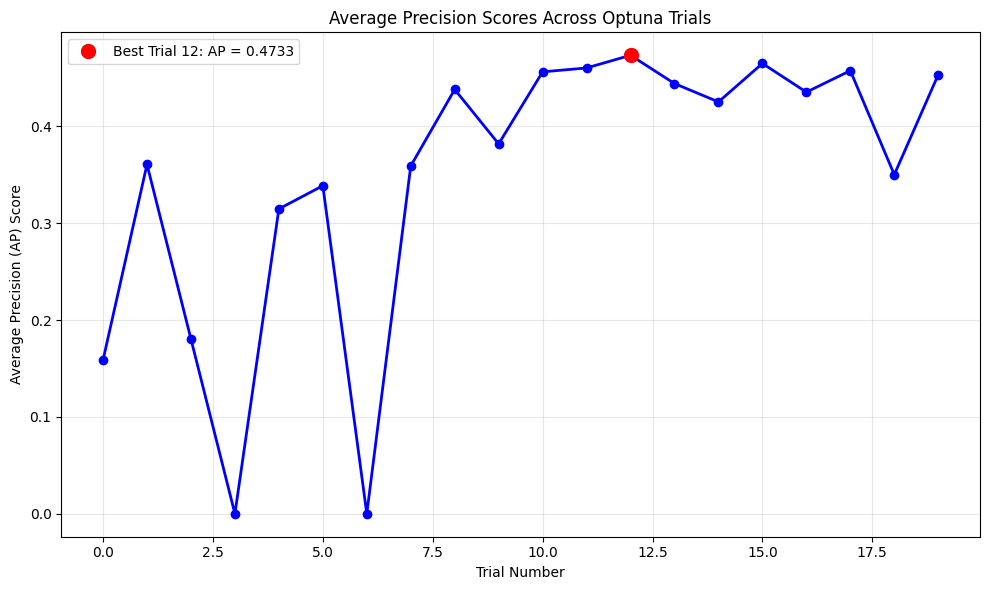

Best AP score: 0.4733 at trial 12
AP score range: 0.0000 - 0.4733


In [71]:
import matplotlib.pyplot as plt

# Extract trial values and objective values (AP scores)
trial_numbers = [trial.number for trial in study.trials]
ap_scores = [trial.value for trial in study.trials]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers, ap_scores, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Trial Number')
plt.ylabel('Average Precision (AP) Score')
plt.title('Average Precision Scores Across Optuna Trials')
plt.grid(True, alpha=0.3)

# Highlight the best trial
best_trial_idx = trial_numbers[ap_scores.index(max(ap_scores))]
best_ap = max(ap_scores)
plt.plot(best_trial_idx, best_ap, 'ro', markersize=10, label=f'Best Trial {best_trial_idx}: AP = {best_ap:.4f}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Best AP score: {best_ap:.4f} at trial {best_trial_idx}")
print(f"AP score range: {min(ap_scores):.4f} - {max(ap_scores):.4f}")

In [ ]:
import matplotlib.pyplot as plt

# Extract trial values and objective values (AP scores)
trial_numbers = [trial.number for trial in study.trials]
ap_scores = [trial.value for trial in study.trials]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers, ap_scores, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Trial Number')
plt.ylabel('Average Precision (AP) Score')
plt.title('Average Precision Scores Across Optuna Trials')
plt.grid(True, alpha=0.3)

# Highlight the best trial
best_trial_idx = trial_numbers[ap_scores.index(max(ap_scores))]
best_ap = max(ap_scores)
plt.plot(best_trial_idx, best_ap, 'ro', markersize=10, label=f'Best Trial {best_trial_idx}: AP = {best_ap:.4f}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Best AP score: {best_ap:.4f} at trial {best_trial_idx}")
print(f"AP score range: {min(ap_scores):.4f} - {max(ap_scores):.4f}")

In [ ]:
hidden_dim = study.best_trial.params['hidden_dim']
n1_gat_layers = study.best_trial.params['n1_gat_layers']
n2_gru_layers = study.best_trial.params['n2_gru_layers']
dropout = study.best_trial.params['dropout']
num_heads = study.best_trial.params['num_heads']
k = study.best_trial.params['k']

model = GraphGRUMortalityModel(input_dim=padded_tensor_train.shape[2], hidden_dim=hidden_dim, n1_gat_layers=n1_gat_layers,
                            n2_gru_layers=n2_gru_layers, X_core=padd_tensor_core, core_padding_mask=padding_mask_core,
                            num_heads=num_heads, dropout=dropout, seq_len=padded_tensor_train.shape[1], k=k, gnn_falg=True).to(DEVICE)


model.train_all(dataloaders, datasets, epochs=15, learning_rate=1e-3)
print("Training completed. Validating on test set...")

acc, auc, pr =  model.validate(dataloaders['test'], datasets['test'])
print(f'Test Accuracy in GNN model: {acc:.4f}, AUC: {auc:.4f}, AP: {pr:.4f}')

In [ ]:
model = GraphGRUMortalityModel(input_dim=padded_tensor_train.shape[2], hidden_dim=hidden_dim, n1_gat_layers=2, n2_gru_layers=2, X_core=padd_tensor_core, 
                               core_padding_mask=padding_mask_core, num_heads=4, dropout=0.1, seq_len=padded_tensor_train.shape[1], k=k, gnn_falg=False).to(DEVICE)

model.train_all(dataloaders, datasets, epochs=15, learning_rate=1e-3)
print("Training completed. Validating on test set...")

acc, auc, pr =  model.validate(dataloaders['test'], datasets['test'])
print(f'Test Accuracy in GNN model: {acc:.4f}, AUC: {auc:.4f}, AP: {pr:.4f}')